In [1]:
########################################
# Packages
########################################
import warnings
import h5py as h5
import numpy as np
import pandas as pd
import multiprocessing as mp

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import math

import statistics

from scipy import stats
from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic
import scipy.stats.distributions as dist

import seaborn as sns

In [2]:
from data_processing import SHARKDataProcessor
processor = SHARKDataProcessor()

# Define subvolume IDs and HDF5 file paths
sv_list = np.arange(64)
sharkfiles = [f'extracted_data_z=0/199/{sv}/galaxies.hdf5' for sv in sv_list] #DEFINE FILE

# Output shark_csv dataframe
shark_csv = processor.process_all_subvolumes(sv_list, sharkfiles)
print(shark_csv.head())

  ID_galaxy ID_subhalo    ID_subhalo_tree ID_halo  sv  type    Mhalo_host  \
0   0_12323        0_1  0_199000000000184     0_1   0     0  1.553645e+12   
1   0_41884        0_2  0_199000000032613     0_1   0     1  1.553645e+12   
2   0_25337        0_4  0_199000000000239     0_2   0     0  1.013176e+12   
3   0_12324        0_4  0_199000000000239     0_2   0     2  1.013176e+12   
4  0_325815        0_5  0_199000000032723     0_2   0     1  1.013176e+12   

          Mhalo   Mstar_bulge    Mstar_disc  ...  SFR_bulge  SFR_disc  \
0  1.406334e+12  4.406725e+10  8.090279e+09  ...   0.239161  8.448190   
1  1.132662e+11  6.663850e+07  3.927870e+08  ...   0.000000  0.045958   
2  7.889350e+11  1.441911e+10  7.342129e+06  ...   5.469577  0.054259   
3  4.321138e+10  4.237961e+08  9.966004e+08  ...   0.000000  0.128186   
4  2.242409e+11  4.860634e+08  7.437644e+08  ...   0.000000  0.316807   

    SFR_all           MBH  MBHacc_cold    MBHacc_hot    MBHacc_all  \
0  8.687351  2.992633e+07   

In [3]:
########################################
# gal_sv settings
########################################
# type: galaxy type; =0 for centrals; =1 for satellites that reside in well identified subhalos; =2 for orphan satellites

shark_csv_centrals = shark_csv[(shark_csv['type'] == 0)] ######## Centrals only
shark_csv_satellites = shark_csv[(shark_csv['type'] == 1)] ######## Satellites only
shark_csv_satANDor = shark_csv[(shark_csv['type'].isin([1, 2]))] ######## Satellites and Orphans

########################################
# Late and Early Type Galaxies
########################################
valid_data = shark_csv['Mstar_all'] > 0

shark_csv_late = (shark_csv['Mstar_disc'] / shark_csv['Mstar_all'] > 0.5) & valid_data  # Late-Type Galaxies (D/T > 0.5)
shark_csv_early = (shark_csv['Mstar_disc'] / shark_csv['Mstar_all'] <= 0.5) & valid_data  # Early-Type Galaxies (D/T <= 0.5)

In [4]:
# DTlessthan05
file_path_DTlessthan05 = "DTlessthan05.csv"
DTlessthan05 = pd.read_csv(file_path_DTlessthan05, header=None)
DTlessthan05.columns = ["Column1", "Column2"]
DTlessthan05 = DTlessthan05.sort_values(by="Column1")
DTlessthan05 = 10 ** DTlessthan05

# DTgreaterthan05
file_path_DTgreaterthan05 = "DTgreaterthan05.csv"
DTgreaterthan05 = pd.read_csv(file_path_DTgreaterthan05, header=None)
DTgreaterthan05.columns = ["Column1", "Column2"]
DTgreaterthan05 = 10 ** DTgreaterthan05

# Correa20_LTGs
file_path_Correa20_LTGs = "Correa20_LTGs.csv"
Correa20_LTGs = pd.read_csv(file_path_Correa20_LTGs, header=None)
Correa20_LTGs.columns = ["Column1", "Column2"]
Correa20_LTGs = 10 ** Correa20_LTGs

# Correa20_ETGs
file_path_Correa20_ETGs = "Correa20_ETGs.csv"
Correa20_ETGs = pd.read_csv(file_path_Correa20_ETGs, header=None)
Correa20_ETGs.columns = ["Column1", "Column2"]
Correa20_ETGs = 10 ** Correa20_ETGs

# Kravstov18_LTGs
file_path_Kravstov18_LTGs = "Kravstov18_LTGs.csv"
Kravstov18_LTGs = pd.read_csv(file_path_Kravstov18_LTGs, header=None)
Kravstov18_LTGs.columns = ["Column1", "Column2"]
Kravstov18_LTGs = 10 ** Kravstov18_LTGs

# Kravstov18_ETGs
file_path_Kravstov18_ETGs = "Kravstov18_ETGs.csv"
Kravstov18_ETGs = pd.read_csv(file_path_Kravstov18_ETGs, header=None)
Kravstov18_ETGs.columns = ["Column1", "Column2"]
Kravstov18_ETGs = 10 ** Kravstov18_ETGs

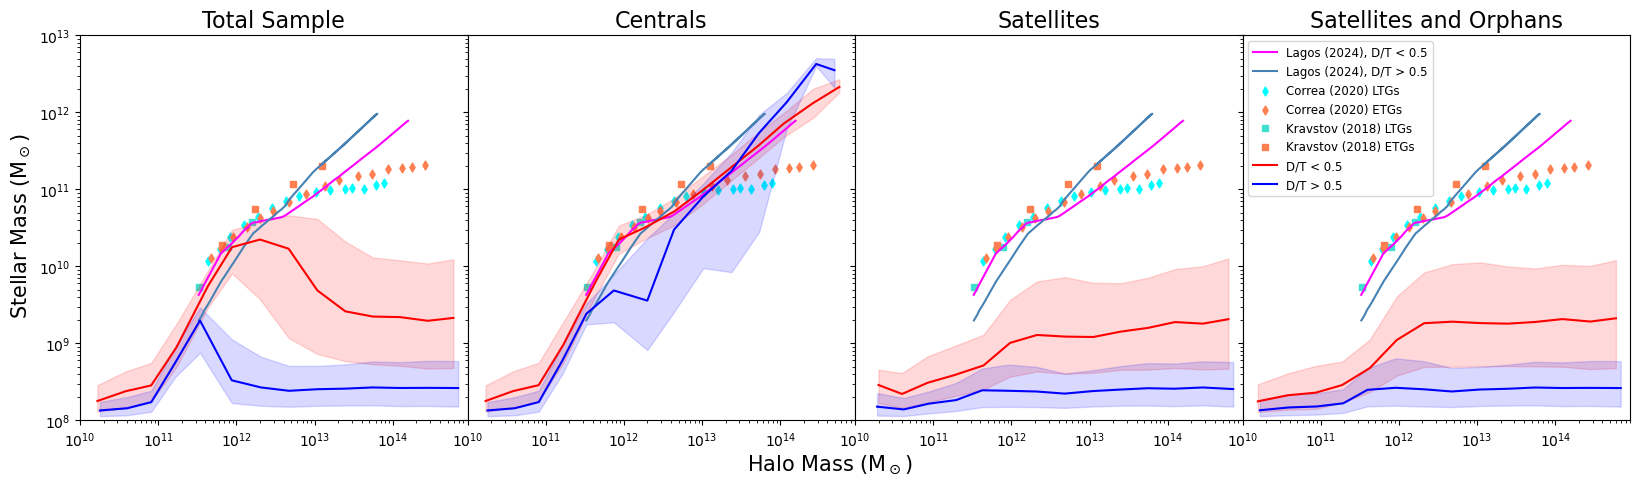

In [5]:
########################################
# Scatter Plots (Stellar vs Halo Mass) ELLIPTICALS vs. CENTRALS
########################################
# List of datasets for easy iteration
datasets = [("Total Sample", shark_csv), 
            ("Centrals", shark_csv_centrals), 
            ("Satellites", shark_csv_satellites), 
            ("Satellites and Orphans", shark_csv_satANDor)]

# Create a 1x4 grid of subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.subplots_adjust(wspace=0)

# Set a shared x and y-axis range
y_min = 10**8
y_max = 10**13
x_min = 10**10
x_max = 9*10**14

# Apply this range and ticks to all subplots
for ax in axs:
    ax.set_ylim([y_min, y_max])
    ax.set_xlim([x_min, x_max])
    ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())  # Use scalar format for readability

# Loop through each dataset and create a plot
for i, (title, data) in enumerate(datasets):
    # Split data into early and late-type galaxies
    early = data[(data['Mstar_disc'] / data['Mstar_all'] <= 0.5)]
    late = data[(data['Mstar_disc'] / data['Mstar_all'] > 0.5)]

    # Function to calculate binned medians and percentiles
    def calculate_binned_stats(data_subset):
        lowLog = math.log10(data_subset['Mhalo_host'].min())
        highLog = math.log10(data_subset['Mhalo_host'].max())
        lowLog = round(lowLog, 0)
        highLog = round(highLog, 0)
        num_bins = 14
        logBins = np.logspace(lowLog, highLog, num=num_bins + 1)

        # Calculate medians
        result = binned_statistic(data_subset['Mhalo_host'], data_subset['Mstar_all'], statistic='median', bins=logBins)
        bin_medians = result.statistic
        
        # Calculate x-values
        xVals = []
        for j in range(len(logBins) - 1):
            bin_data = data_subset['Mhalo_host'][(data_subset['Mhalo_host'] >= logBins[j]) & (data_subset['Mhalo_host'] < logBins[j+1])]
            if len(bin_data) > 0:
                xVals.append(np.median(bin_data))
            else:
                xVals.append(np.nan)

        xVals = np.array(xVals)
        valid_bins = ~np.isnan(xVals)
        xVals = xVals[valid_bins]
        bin_medians = bin_medians[valid_bins]

        # Percentiles
        percentile_25 = binned_statistic(data_subset['Mhalo_host'], data_subset['Mstar_all'], 
                                         statistic=lambda values: np.percentile(values, 25), bins=logBins)
        p25 = percentile_25.statistic[valid_bins]
        percentile_75 = binned_statistic(data_subset['Mhalo_host'], data_subset['Mstar_all'], 
                                         statistic=lambda values: np.percentile(values, 75), bins=logBins)
        p75 = percentile_75.statistic[valid_bins]

        return xVals, bin_medians, p25, p75

    # Calculate stats for early and late galaxies
    xVals_early, bin_medians_early, p25_early, p75_early = calculate_binned_stats(early)
    xVals_late, bin_medians_late, p25_late, p75_late = calculate_binned_stats(late)

    # Plot supplementary plots
        #Lagos 2024 early/late plot
    axs[i].plot(DTlessthan05["Column1"], DTlessthan05["Column2"], color='magenta', 
                   linestyle='-', linewidth=1.5, label='Lagos (2024), D/T < 0.5') #DTlessthan05
    axs[i].plot(DTgreaterthan05["Column1"], DTgreaterthan05["Column2"], color='steelblue', 
                   linestyle='-', linewidth=1.5, label='Lagos (2024), D/T > 0.5') #DTgreaterthan05
    
    axs[i].scatter(Correa20_LTGs["Column1"], Correa20_LTGs["Column2"], color='aqua', s=20, marker="d", label='Correa (2020) LTGs') #Correa20_LTGs
    axs[i].scatter(Correa20_ETGs["Column1"], Correa20_ETGs["Column2"], color='coral', s=20, marker="d", label='Correa (2020) ETGs') #Correa20_ETGs
    
    axs[i].scatter(Kravstov18_LTGs["Column1"], Kravstov18_LTGs["Column2"], color='turquoise', s=20, marker="s", label='Kravstov (2018) LTGs') #Kravstov18_LTGs
    axs[i].scatter(Kravstov18_ETGs["Column1"], Kravstov18_ETGs["Column2"], color='coral', s=20, marker="s", label='Kravstov (2018) ETGs') #Kravstov18_ETGs

    # Plot early-type galaxies (blue)
    axs[i].plot(xVals_early, bin_medians_early, color='red', linestyle='-', linewidth=1.5, label='D/T < 0.5')
    axs[i].fill_between(xVals_early, p25_early, p75_early, color='red', alpha=0.15)

    # Plot late-type galaxies (red)
    axs[i].plot(xVals_late, bin_medians_late, color='blue', linestyle='-', linewidth=1.5, label='D/T > 0.5')
    axs[i].fill_between(xVals_late, p25_late, p75_late, color='blue', alpha=0.15)

    # Set titles and remove y-axis labels for intermediate plots
    axs[i].set_title(f'{title}', fontsize=16)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlim([x_min, x_max])
    axs[i].set_ylim([y_min, y_max])

# Add a single x-axis and y-axis label
fig.text(0.5, 0.01, r'Halo Mass (M$_\odot$)', ha='center', fontsize=15)
fig.text(0.09, 0.5, r'Stellar Mass (M$_\odot$)', va='center', rotation='vertical', fontsize=15)

plt.legend(loc="upper left", fontsize = 8.5)
plt.show()

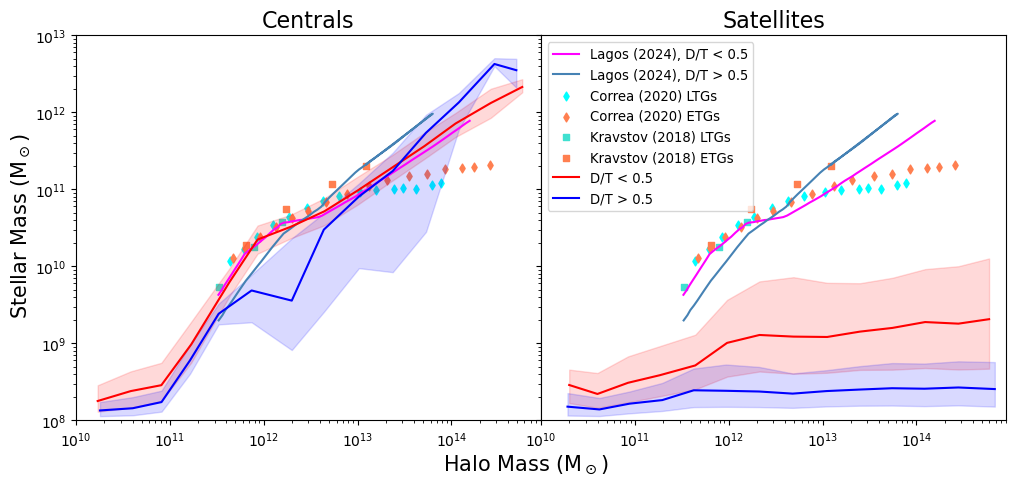

In [34]:
########################################
# Scatter Plots (Stellar vs Halo Mass) ELLIPTICALS vs. CENTRALS <<Poster Version>>
########################################
# List of datasets for easy iteration
datasets = [("Centrals", shark_csv_centrals), 
            ("Satellites", shark_csv_satellites)]

# Create a 1x4 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.subplots_adjust(wspace=0)

# Set a shared x and y-axis range
y_min = 10**8
y_max = 10**13
x_min = 10**10
x_max = 9*10**14

# Apply this range and ticks to all subplots
for ax in axs:
    ax.set_ylim([y_min, y_max])
    ax.set_xlim([x_min, x_max])
    ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())  # Use scalar format for readability

# Loop through each dataset and create a plot
for i, (title, data) in enumerate(datasets):
    # Split data into early and late-type galaxies
    early = data[(data['Mstar_disc'] / data['Mstar_all'] <= 0.5)]
    late = data[(data['Mstar_disc'] / data['Mstar_all'] > 0.5)]

    # Function to calculate binned medians and percentiles
    def calculate_binned_stats(data_subset):
        lowLog = math.log10(data_subset['Mhalo_host'].min())
        highLog = math.log10(data_subset['Mhalo_host'].max())
        lowLog = round(lowLog, 0)
        highLog = round(highLog, 0)
        num_bins = 14
        logBins = np.logspace(lowLog, highLog, num=num_bins + 1)

        # Calculate medians
        result = binned_statistic(data_subset['Mhalo_host'], data_subset['Mstar_all'], statistic='median', bins=logBins)
        bin_medians = result.statistic
        
        # Calculate x-values
        xVals = []
        for j in range(len(logBins) - 1):
            bin_data = data_subset['Mhalo_host'][(data_subset['Mhalo_host'] >= logBins[j]) & (data_subset['Mhalo_host'] < logBins[j+1])]
            if len(bin_data) > 0:
                xVals.append(np.median(bin_data))
            else:
                xVals.append(np.nan)

        xVals = np.array(xVals)
        valid_bins = ~np.isnan(xVals)
        xVals = xVals[valid_bins]
        bin_medians = bin_medians[valid_bins]

        # Percentiles
        percentile_25 = binned_statistic(data_subset['Mhalo_host'], data_subset['Mstar_all'], 
                                         statistic=lambda values: np.percentile(values, 25), bins=logBins)
        p25 = percentile_25.statistic[valid_bins]
        percentile_75 = binned_statistic(data_subset['Mhalo_host'], data_subset['Mstar_all'], 
                                         statistic=lambda values: np.percentile(values, 75), bins=logBins)
        p75 = percentile_75.statistic[valid_bins]

        return xVals, bin_medians, p25, p75

    # Calculate stats for early and late galaxies
    xVals_early, bin_medians_early, p25_early, p75_early = calculate_binned_stats(early)
    xVals_late, bin_medians_late, p25_late, p75_late = calculate_binned_stats(late)

    # Plot supplementary plots
        #Lagos 2024 early/late plot
    axs[i].plot(DTlessthan05["Column1"], DTlessthan05["Column2"], color='magenta', 
                   linestyle='-', linewidth=1.5, label='Lagos (2024), D/T < 0.5') #DTlessthan05
    axs[i].plot(DTgreaterthan05["Column1"], DTgreaterthan05["Column2"], color='steelblue', 
                   linestyle='-', linewidth=1.5, label='Lagos (2024), D/T > 0.5') #DTgreaterthan05
    
    axs[i].scatter(Correa20_LTGs["Column1"], Correa20_LTGs["Column2"], color='aqua', s=20, marker="d", label='Correa (2020) LTGs') #Correa20_LTGs
    axs[i].scatter(Correa20_ETGs["Column1"], Correa20_ETGs["Column2"], color='coral', s=20, marker="d", label='Correa (2020) ETGs') #Correa20_ETGs
    
    axs[i].scatter(Kravstov18_LTGs["Column1"], Kravstov18_LTGs["Column2"], color='turquoise', s=20, marker="s", label='Kravstov (2018) LTGs') #Kravstov18_LTGs
    axs[i].scatter(Kravstov18_ETGs["Column1"], Kravstov18_ETGs["Column2"], color='coral', s=20, marker="s", label='Kravstov (2018) ETGs') #Kravstov18_ETGs

    # Plot early-type galaxies (blue)
    axs[i].plot(xVals_early, bin_medians_early, color='red', linestyle='-', linewidth=1.5, label='D/T < 0.5')
    axs[i].fill_between(xVals_early, p25_early, p75_early, color='red', alpha=0.15)

    # Plot late-type galaxies (red)
    axs[i].plot(xVals_late, bin_medians_late, color='blue', linestyle='-', linewidth=1.5, label='D/T > 0.5')
    axs[i].fill_between(xVals_late, p25_late, p75_late, color='blue', alpha=0.15)

    # Set titles and remove y-axis labels for intermediate plots
    axs[i].set_title(f'{title}', fontsize=16)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlim([x_min, x_max])
    axs[i].set_ylim([y_min, y_max])

# Add a single x-axis and y-axis label
fig.text(0.5, 0.01, r'Halo Mass (M$_\odot$)', ha='center', fontsize=15)
fig.text(0.07, 0.5, r'Stellar Mass (M$_\odot$)', va='center', rotation='vertical', fontsize=15)

plt.legend(loc="upper left", fontsize = 9.5)
plt.show()

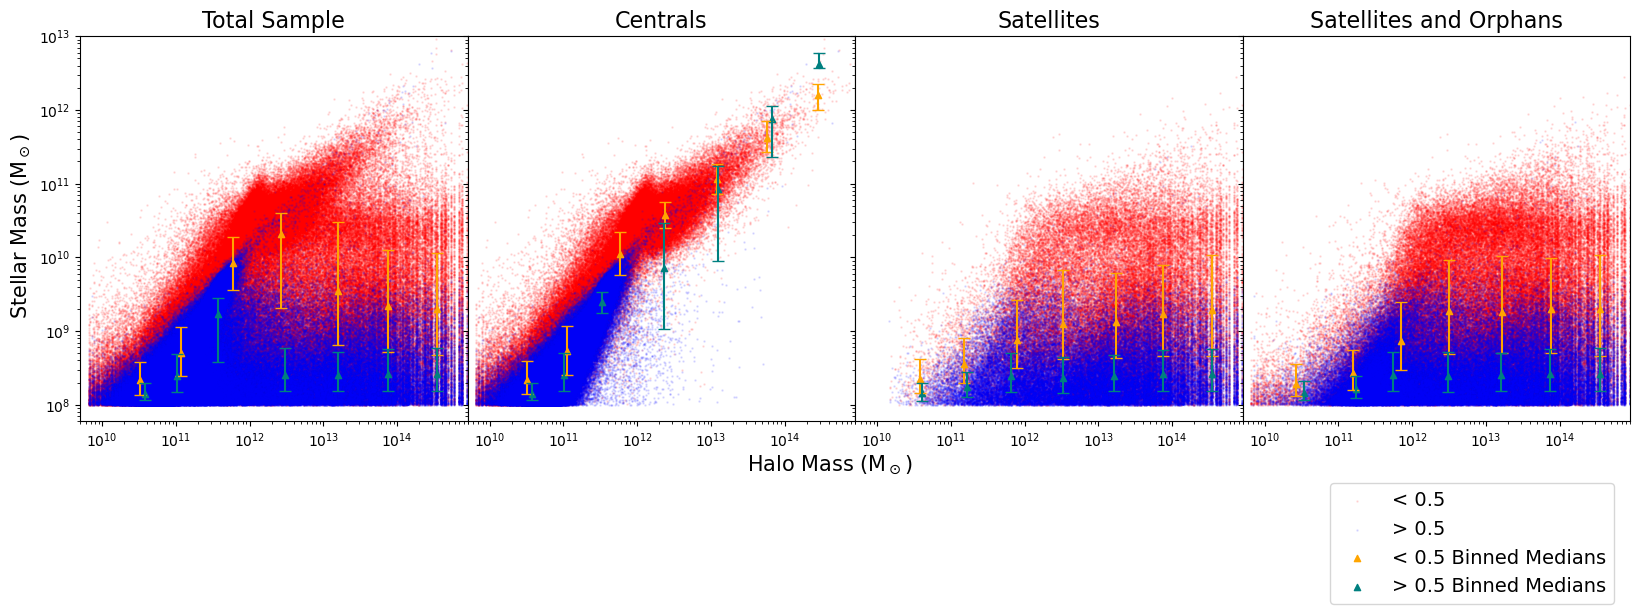

In [6]:
########################################
# Scatter Plots (Stellar vs Halo Mass) ELLIPTICALS vs. CENTRALS
########################################
# List of datasets for easy iteration
datasets = [("Total Sample", shark_csv), 
            ("Centrals", shark_csv_centrals), 
            ("Satellites", shark_csv_satellites), 
            ("Satellites and Orphans", shark_csv_satANDor)]

# Create a 1x4 grid of subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.subplots_adjust(wspace=0)

# Set a shared x and y-axis range
y_min = 6*10**7
y_max = 10**13
x_min = 5*10**9
x_max = 9*10**14

# Apply this range and ticks to all subplots
for ax in axs:
    ax.set_ylim([y_min, y_max])
    ax.set_xlim([x_min, x_max])
    ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())  # Use scalar format for readability

# Loop through each dataset and create a plot
for i, (title, data) in enumerate(datasets):
    # Split data into early and late-type galaxies
    early = data[(data['Mstar_disc'] / data['Mstar_all'] <= 0.5)]
    late = data[(data['Mstar_disc'] / data['Mstar_all'] > 0.5)]

    # Function to calculate binned medians and percentiles
    def calculate_binned_stats(data_subset):
        lowLog = math.log10(data_subset['Mhalo_host'].min())
        highLog = math.log10(data_subset['Mhalo_host'].max())
        lowLog = round(lowLog, 0)
        highLog = round(highLog, 0)
        num_bins = 7
        logBins = np.logspace(lowLog, highLog, num=num_bins + 1)

        # Calculate medians
        result = binned_statistic(data_subset['Mhalo_host'], data_subset['Mstar_all'], statistic='median', bins=logBins)
        bin_medians = result.statistic

        # Calculate x-values
        xVals = []
        for j in range(len(logBins) - 1):
            bin_data = data_subset['Mhalo_host'][(data_subset['Mhalo_host'] >= logBins[j]) & (data_subset['Mhalo_host'] < logBins[j+1])]
            if len(bin_data) > 0:
                xVals.append(np.median(bin_data))
            else:
                xVals.append(np.nan)

        xVals = np.array(xVals)
        valid_bins = ~np.isnan(xVals)
        xVals = xVals[valid_bins]
        bin_medians = bin_medians[valid_bins]

        # Percentiles
        percentile_25 = binned_statistic(data_subset['Mhalo_host'], data_subset['Mstar_all'], 
                                         statistic=lambda values: np.percentile(values, 25), bins=logBins)
        p25 = percentile_25.statistic[valid_bins]
        percentile_75 = binned_statistic(data_subset['Mhalo_host'], data_subset['Mstar_all'], 
                                         statistic=lambda values: np.percentile(values, 75), bins=logBins)
        p75 = percentile_75.statistic[valid_bins]

        return xVals, bin_medians, p25, p75

    # Calculate stats for early and late galaxies
    xVals_early, bin_medians_early, p25_early, p75_early = calculate_binned_stats(early)
    xVals_late, bin_medians_late, p25_late, p75_late = calculate_binned_stats(late)

    #Scatter plots
    axs[i].scatter(early['Mhalo_host'], early['Mstar_all'], s=0.8, alpha=0.1, color='red', label='< 0.5')
    axs[i].scatter(late['Mhalo_host'], late['Mstar_all'], s=0.8, alpha=0.1, color='blue', label='> 0.5')
    
    # Plot early-type galaxies (blue)
    axs[i].scatter(xVals_early, bin_medians_early, s=20, color='orange', marker="^", label='< 0.5 Binned Medians')
    axs[i].errorbar(xVals_early, bin_medians_early, 
                    yerr=[bin_medians_early - p25_early, p75_early - bin_medians_early], 
                    fmt='none', ecolor='orange', capsize=4)

    # Plot late-type galaxies (red)
    axs[i].scatter(xVals_late, bin_medians_late, s=20, color='teal', marker="^", label='> 0.5 Binned Medians')
    axs[i].errorbar(xVals_late, bin_medians_late, 
                    yerr=[bin_medians_late - p25_late, p75_late - bin_medians_late], 
                    fmt='none', ecolor='teal', capsize=4)

    # Set titles and remove y-axis labels for intermediate plots
    axs[i].set_title(f'{title}', fontsize=16)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlim([x_min, x_max])
    axs[i].set_ylim([y_min, y_max])

# Add a single x-axis and y-axis label
fig.text(0.5, 0.01, r'Halo Mass (M$_\odot$)', ha='center', fontsize=15)
fig.text(0.09, 0.5, r'Stellar Mass (M$_\odot$)', va='center', rotation='vertical', fontsize=15)

plt.legend(loc="lower left", bbox_to_anchor = (0.2,-0.5), fontsize = 14)
plt.show()